Add: 
    - 6 Months around brexit for final Frame. Full for user party affiliation.
    - Only Lemmatized posts : Brexit, referendum, leave, remain, vote
    - Higher boundary to assign score. +- 5
    

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import load_data
from constants import *
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Bad key text.latex.preview in file /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

In [3]:
dev = False

def txt_to_list(data_path):
    with open(data_path, "r") as f:
        data = f.read().splitlines()

        return data

STOPWORDS = txt_to_list(f"{INPUT_DIR}/stopwords.txt")

In [4]:
YEARS = [2016]
reddit = {}

In [5]:
for year in YEARS:
    reddit[year] = load_data(DATA_PATH, year=year, tokenize=False, comp="parquet", dev=False)

Loading data of 2016...


In [6]:
if dev:
    reduction_frac =0.15
    print('Reduce data to fraction {}'.format(reduction_frac))
    for year in YEARS:
        reddit[year] = reddit[year].sample(frac=reduction_frac)

In [7]:
users = {}

for year in YEARS:
    print(year)
    for index, row in reddit[year].iterrows():
        if not row['subreddit'] in DEM_SUBREDDITS and not row['subreddit'] in REP_SUBREDDITS:
            continue
        else:
            try:
                users[row['author']].append(row['subreddit'])
            except KeyError:
                users[row['author']] = [row['subreddit']]


2016


In [8]:
users_n_posts_df = pd.DataFrame([[user, len(users[user])] for user in users.keys()],
                                columns = ['user', 'n_posts'])
users_n_posts_df.to_csv('users_n_posts.csv')

In [9]:
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from datetimerange import DateTimeRange

st = LancasterStemmer()

BREXIT = 'brexit'
#BREX_LEMMAS= set([st.stem(word) for word in ['leave', 'remain']:
                  #['vote', 'leave', 'remain', 'referendum', 'cameron', 'uk', 'british']])
BREXIT_DATE = pd.to_datetime('2016-06-23')
START_RANGE = BREXIT_DATE - pd.Timedelta(90, unit='d')
END_RANGE = BREXIT_DATE + pd.Timedelta(90, unit='d')



def includes_lemma(post):
    tokens = filter(lambda token: token not in string.punctuation, word_tokenize(post))
    tokens = [t for t in tokens if t not in STOPWORDS]
    tokenized_post = set([st.stem(token.lower()) for token in tokens])
    if BREXIT in tokenized_post:            
        return True
    #elif np.sum([lemm in BREX_LEMMAS for lemm in tokenized_post]) >= 2:
    #    return True
    return False

def is_six_months_around_brexit(date):
    time_range = DateTimeRange(START_RANGE, END_RANGE)
    timestamp = pd.to_datetime(date)
    if timestamp in time_range:
        return True
    else:
        return False

In [10]:
def rep_or_dem_score(subreddits_list):
    score = 0
    for subreddit in subreddits_list:
        if subreddit in DEM_SUBREDDITS:
            score += 1
        elif subreddit in REP_SUBREDDITS:
            score -= 1
    return score

def rep_or_dem(score):
    if score >=1 : 
        return 'D'
    elif score <= -1:
        return 'R'
    return 'N'


In [11]:
user_affiliation = {}
users_affiliation_data = []
for key in users.keys():
    aff = rep_or_dem_score(users[key])
    if abs(aff) > 5:
        users_affiliation_data.append([key, aff,rep_or_dem(aff)])
        user_affiliation[key] = rep_or_dem(aff)

users_affiliation_df = pd.DataFrame(users_affiliation_data, columns=['user', 'score', 'leaning'])

In [12]:
print(users_affiliation_df)

                    user  score leaning
0           bannanaflame  -1104       R
1                 matts2  -1826       R
2           Voltairinede    487       D
3         JustDoinThings   -711       R
4                 Jcas11   -200       R
...                  ...    ...     ...
24939  FamilialAnarchist      7       D
24940       Greatone123x     -9       R
24941          chris2315     10       D
24942             DBCDBC     -6       R
24943          OmarAdelX     -9       R

[24944 rows x 3 columns]


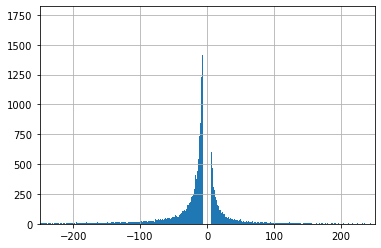

In [13]:
users_affiliation_df['score'].hist(bins=np.linspace(-250, 250, 500))
#plt.semilogx()
plt.xlim(-250,250)
plt.show()

In [14]:
users_affiliation_df.to_csv('BREXIT_user_affiliation.csv')

In [15]:
#for year in YEARS:
#    reddit[year] = reddit[year].sample(frac=0.20)

In [ ]:
data = []
relevant_users = set(user_affiliation.keys())
for year in YEARS:
    print('YEAR -> ', year)
    reddit[year] = reddit[year][reddit[year]['subreddit']== 'politics'].compute()
    if dev:
        reddit[year] = reddit[year].iloc[np.random.randint(0, 
                                                           len(reddit[year]),
                                                           size = int(0.15*len(reddit[year])))]
    author_ = reddit[year].author.values
    created_ = reddit[year].created_utc.values
    body_ =  reddit[year].body.values
    for author, created, body in zip(author_, created_, body_):
        if author in relevant_users:
            if is_six_months_around_brexit(created):
                if includes_lemma(body):
                    affiliation = user_affiliation[author] 
                    new_line = [author, body, created, affiliation]
                    data.append(new_line)
                
output_dataframe = pd.DataFrame(data, columns= ['author', 'post', 'time', 'politics'])


YEAR ->  2016


In [ ]:
output_dataframe.to_csv('BREXIT_data_{}_rows.csv'.format(len(output_dataframe)))

In [ ]:
output_dataframe

In [ ]:
output_dataframe['politics'].hist()
plt.show()